# SECS-Based Magnetometer Data Analysis
This notebook processes magnetometer data using Spherical Elementary Current Systems (SECS) to analyze magnetic field components and saves the results.


## 1. Import Libaries and helper functions

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import argparse

# Import SECSY library components for Spherical Elementary Current Systems calculations
from secsy import cubedsphere as cs  # Handles cubed sphere projections and grid operations
from secsy import get_SECS_B_G_matrices  # Calculates SECS basis function matrices
from secsy import CSplot 

# Import helper functions
from helper_functions import (
    create_dir, load_magnetometer_data, trailing_average, get_common_stations,
    create_secs_directories, save_magnetic_component, save_grid_metadata
)

## 2. Set up configuration parameters

In [2]:
# Time-related parameters
start_date_str = "2024-02-05 12:00"
end_date_str = "2024-02-05 13:00"
time_resolution = 1  # minutes

# Grid-related parameters
grid_center = [17.0, 67.0]  # [longitude, latitude] in degrees
grid_shape = [30, 18]  # [N-S points, E-W points]
grid_resolution = 1e5  # meters

# Regularization parameters
l0 = 1e-2  # Zero-order (amplitude) regularization strength
l1 = 1e-2  # First-order (smoothness) regularization strength

# Mirror method parameters
mirror_depth = 1000  # km (9999 to disable)

# Parse dates
start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d %H:%M')

print(f"Analysis period: {start_date} to {end_date}")
print(f"Time resolution: {time_resolution} minutes")
print(f"Grid center: {grid_center[0]}°E, {grid_center[1]}°N")
print(f"Grid shape: {grid_shape[0]}×{grid_shape[1]} points")
print(f"Grid resolution: {grid_resolution/1000:.1f} km")
print(f"Mirror depth: {'Disabled' if mirror_depth == 9999 else f'{mirror_depth} km'}")

Analysis period: 2024-02-05 12:00:00 to 2024-02-05 13:00:00
Time resolution: 1 minutes
Grid center: 17.0°E, 67.0°N
Grid shape: 30×18 points
Grid resolution: 100.0 km
Mirror depth: 1000 km


## 3. Data loading

In [3]:
RE = 6371e3  # Earth radius in meters

# Define data directories for X, Y, Z components
base_dir = '/Users/akv020/Tensorflow/fennomag-net/data'
Xdir = os.path.join(base_dir, 'XYZmagnetometer/X')
Ydir = os.path.join(base_dir, 'XYZmagnetometer/Y')
Zdir = os.path.join(base_dir, 'XYZmagnetometer/Z')

# Load magnetometer data for all components within specified time range
print("Loading magnetometer data...")
data = load_magnetometer_data(start_date, end_date, Xdir, Ydir, Zdir)
if any(data[comp] is None for comp in ['X', 'Y', 'Z']):
    raise ValueError("Could not load all magnetometer data files")

# Display data summary
for comp in ['X', 'Y', 'Z']:
    print(f"{comp} component data shape: {data[comp].shape}")
    print(f"Time range: {data[comp]['timestamp'].min()} to {data[comp]['timestamp'].max()}")
    print(f"Number of stations: {len(data[comp].columns) - 1}")  # -1 for timestamp column
    print()

Loading magnetometer data...
X component data shape: (61, 42)
Time range: 2024-02-05 12:00:00 to 2024-02-05 13:00:00
Number of stations: 41

Y component data shape: (61, 42)
Time range: 2024-02-05 12:00:00 to 2024-02-05 13:00:00
Number of stations: 41

Z component data shape: (61, 42)
Time range: 2024-02-05 12:00:00 to 2024-02-05 13:00:00
Number of stations: 41



## 4. Station Coordinates Processing

In [4]:
# Load station coordinates and prepare for processing
station_coords_file = os.path.join(base_dir, 'magnetometer/station_coordinates.csv')
station_coordinates = pd.read_csv(station_coords_file)
station_coordinates.set_index('station', inplace=True)

# Display station coordinates summary
print(f"Total stations in coordinates file: {len(station_coordinates)}")
print(station_coordinates.head())

# Filter stations to keep only those with both coordinates and measurements
common_stations = get_common_stations(data, station_coordinates)
print(f"\nNumber of common stations with both coordinates and measurements: {len(common_stations)}")
print(f"Common stations: {', '.join(common_stations[:5])}{'...' if len(common_stations) > 5 else ''}")

for comp in ['X', 'Y', 'Z']:
    columns_to_keep = ['timestamp'] + common_stations
    data[comp] = data[comp][columns_to_keep]
station_coordinates = station_coordinates.loc[common_stations]

Total stations in coordinates file: 39
         latitude  longitude
station                     
jan1a     70.9000    -8.7000
nor1a     71.0917    25.7856
sor1a     70.5414    22.2247
rst1a     67.5300    12.0986
har1a     60.2100    10.7500

Number of common stations with both coordinates and measurements: 39
Common stations: lyr2a, sod1a, pel1a, roe1d, kil1a...


## 5. Visualize the grid

/Users/akv020/Tensorflow/Bcast/source/secsy/src/secsy/csplot.py:573: RuntimeWarning: Mean of empty slice
  return np.rad2deg(np.arctan2(np.nanmean(np.sin(np.deg2rad(X)),axis=axis),np.nanmean(np.cos(np.deg2rad(X)),axis=axis)))
/Users/akv020/Tensorflow/Bcast/source/secsy/src/secsy/csplot.py:221: RuntimeWarning: Mean of empty slice
  lat_mean = np.nanmean(np.where(~iii,np.nan,lat[:,None]),axis=0) # mean of lat grid lines


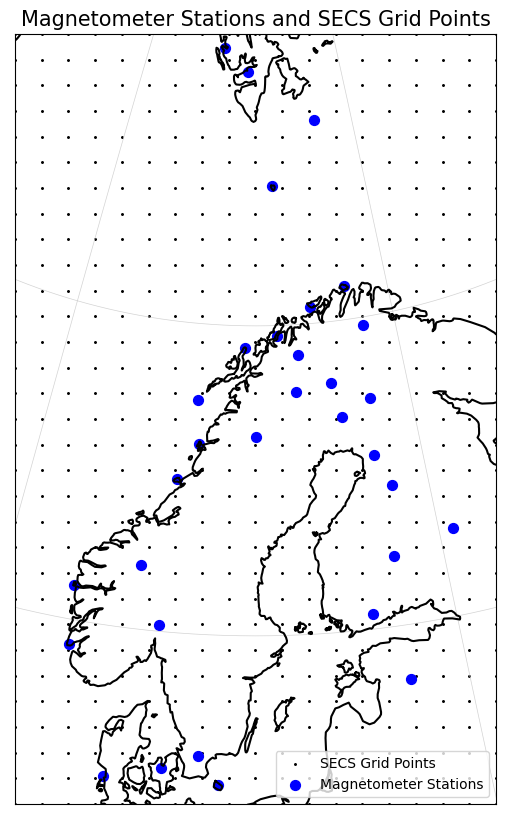

In [5]:
# Define Earth radius and grid altitude
ionosphere = True
Rgrid = RE + 110e3 if ionosphere else RE  # Place grid at ionospheric altitude or ground


# Set up cubed sphere projection for station visualization
projection = cs.CSprojection((grid_center[0], grid_center[1]), 0)  # central (lon, lat) and orientation
grid = cs.CSgrid(projection, grid_shape[1] * grid_resolution, grid_shape[0] * grid_resolution, 
                     grid_shape[0], grid_shape[1], R=Rgrid, wshift=1e3)

# Plot station locations using CSplot
fig, ax = plt.subplots(figsize=(10, 10))
csax = CSplot(ax, grid, gridtype='geo')
csax.ax.set_title('Magnetometer Stations and SECS Grid Points', size=15)
csax.add_coastlines(color='black', resolution='50m')

# Plot SECS grid points and station locations
csax.scatter(grid.lon_mesh, grid.lat_mesh, marker='.', s=5, color='black', label='SECS Grid Points')
csax.scatter(station_coordinates.longitude, station_coordinates.latitude, marker='o', s=50, color='blue', label='Magnetometer Stations')

# Add legend
plt.legend(loc='best')
plt.show()

## 6. SECS Inversion Setup

In [6]:
# Define regularization parameters for the inverse problem
print(f"Regularization parameters: l0={l0}, l1={l1}")

# Calculate regularization matrices using grid's built-in methods
De, Dn = grid.get_Le_Ln()  # Get matrices for E-W and N-S derivatives
DTD = De.T @ De + Dn.T @ Dn  # Combined regularization matrix

# Get station coordinates for SECS basis function calculation
lon_mag = station_coordinates.longitude.values
lat_mag = station_coordinates.latitude.values

# Check which stations are inside the grid
print("Checking which stations are inside the grid...")
print(f"Number of stations to check: {len(common_stations)}")
print(f"Shape of lon_mag: {lon_mag.shape}, lat_mag: {lat_mag.shape}")

# Make sure we're checking the same stations that are in common_stations
stations_in_grid = []
stations_inside = []
stations_outside = []

for station in common_stations:
    if station in station_coordinates.index:
        lon = station_coordinates.loc[station, 'longitude']
        lat = station_coordinates.loc[station, 'latitude']
        is_inside = grid.ingrid(lon, lat)
        stations_in_grid.append(is_inside)
        
        if is_inside:
            stations_inside.append(station)
        else:
            stations_outside.append(station)

print(f"Stations inside grid: {len(stations_inside)}/{len(common_stations)}")
if stations_outside:
    print(f"Dropping stations outside grid: {', '.join(stations_outside)}")

# Filter data and coordinates to keep only stations inside the grid
for comp in ['X', 'Y', 'Z']:
    columns_to_keep = ['timestamp'] + stations_inside
    data[comp] = data[comp][columns_to_keep]
station_coordinates = station_coordinates.loc[stations_inside]

# Update station coordinates after filtering
lon_mag = station_coordinates.longitude.values
lat_mag = station_coordinates.latitude.values

# Calculate SECS basis function matrices relating current amplitudes to magnetic field components
print("Calculating SECS basis matrices for stations...")
induction_nullification_radius = RE - mirror_depth * 1000 if mirror_depth != 9999 else None
if induction_nullification_radius is not None:
    print(f"Using mirror method with superconducting layer at depth {mirror_depth} km")
else:
    print("Mirror method disabled")
    
GeB_mag, GnB_mag, GuB_mag = get_SECS_B_G_matrices(
    lat_mag, lon_mag, RE, grid.lat, grid.lon,
    induction_nullification_radius=induction_nullification_radius
)

print(f"SECS basis matrices shapes: {GeB_mag.shape}, {GnB_mag.shape}, {GuB_mag.shape}")

# Get list of stations for inversion
station_cols = [col for col in data['X'].columns if col != 'timestamp']
good_stations = station_cols
print(f"Number of stations for inversion: {len(good_stations)}")

Regularization parameters: l0=0.01, l1=0.01
Checking which stations are inside the grid...
Number of stations to check: 39
Shape of lon_mag: (39,), lat_mag: (39,)
Stations inside grid: 32/39
Dropping stations outside grid: nrd1d, kul2d, hov1d, amk1f, lrv1a, sco2d, jan1a
Calculating SECS basis matrices for stations...
Using mirror method with superconducting layer at depth 1000 km
SECS basis matrices shapes: (32, 540), (32, 540), (32, 540)
Number of stations for inversion: 32


In [7]:
# 7. Build Covariance Matrix
# ---------------------
# Build covariance matrix from magnetic field components
print("Building covariance matrix from magnetic field components...")

# Extract magnetic field data for all stations
By_day = data['Y'][good_stations].values
Bx_day = data['X'][good_stations].values
Bz_day = -data['Z'][good_stations].values  # Note: Z component is negated

# Display shapes of magnetic field component arrays
print(f"Magnetic field component shapes: Bx={Bx_day.shape}, By={By_day.shape}, Bz={Bz_day.shape}")

# Combine all magnetic field components for covariance calculation
D_all = np.hstack([By_day, Bx_day, Bz_day])
mask = np.isnan(D_all)
D_all_ma = np.ma.array(D_all, mask=mask)

# Calculate correlation coefficient matrix between components
print("Calculating correlation matrix...")
cv = np.ma.corrcoef(D_all_ma.T)
cv = np.ma.filled(cv, fill_value=0.0)

# Calculate inverse of correlation matrix for weighting
print("Calculating inverse correlation matrix...")
cvinv = np.linalg.lstsq(cv, np.eye(cv.shape[0]), rcond=None)[0]

print(f"Correlation matrix shape: {cv.shape}")

# Explain the regularization approach
print("\nRegularization approach:")
print("Using a combination of:")
print("1. Zero-order Tikhonov regularization (damping the amplitude)")
print("2. First-order Tikhonov regularization (smoothing)")
print("3. Correlation-based weighting of measurements")
print(f"Regularization parameters: l0={l0}, l1={l1}")

Building covariance matrix from magnetic field components...
Magnetic field component shapes: Bx=(61, 32), By=(61, 32), Bz=(61, 32)
Calculating correlation matrix...
Calculating inverse correlation matrix...
Correlation matrix shape: (96, 96)

Regularization approach:
Using a combination of:
1. Zero-order Tikhonov regularization (damping the amplitude)
2. First-order Tikhonov regularization (smoothing)
3. Correlation-based weighting of measurements
Regularization parameters: l0=0.01, l1=0.01


In [8]:
# 8. Calculate SECS Matrices for Full Grid
# ----------------------------------
print("Calculating SECS matrices for the full grid...")

# Initialize magnetic field component arrays
Be = np.full(grid.lat_mesh.shape, np.nan)
Bn = np.full(grid.lat_mesh.shape, np.nan)
Bu = np.full(grid.lat_mesh.shape, np.nan)

# Calculate SECS matrices for the full grid
print(f"Calculating SECS matrices for {grid.size} grid points...")
GeB_full, GnB_full, GuB_full = get_SECS_B_G_matrices(
    grid.lat_mesh.flatten(),
    grid.lon_mesh.flatten(),
    RE,
    grid.lat,
    grid.lon,
    induction_nullification_radius=induction_nullification_radius
)
print("SECS matrices calculated successfully")
print(f"Matrix shapes: {GeB_full.shape}, {GnB_full.shape}, {GuB_full.shape}")

Calculating SECS matrices for the full grid...
Calculating SECS matrices for 540 grid points...
SECS matrices calculated successfully
Matrix shapes: (589, 540), (589, 540), (589, 540)


In [9]:
# 9. Time Averaging
# ------------
print("Applying trailing average...")
for comp in ['X', 'Y', 'Z']:
    data[comp] = trailing_average(data[comp], interval_minutes=time_resolution)
    
timestamps = pd.to_datetime(data['X']['timestamp'])
print(f"Number of timestamps after averaging: {len(timestamps)}")
print(f"First timestamp: {timestamps.min()}")
print(f"Last timestamp: {timestamps.max()}")

Applying trailing average...
Number of timestamps after averaging: 61
First timestamp: 2024-02-05 12:00:00
Last timestamp: 2024-02-05 13:00:00


In [11]:
# 10. Process Timestamps and Calculate Fields (with improved visualization)
# ------------------------------------
# Initialize storage for results
I_timestamps = {}  # Store current amplitudes for each timestamp
base_path = '/Users/akv020/Tensorflow/fennomag-net/data/secs'
total_timestamps = len(timestamps)

# Create directories for SECS components
create_secs_directories(base_path, start_date.year)

# Save grid metadata once at the start
save_grid_metadata(grid, base_path, grid_resolution, grid_shape, start_date.year)

# Process a subset of timestamps for demonstration
demo_timestamps = timestamps[:min(5, len(timestamps))]  # Process first 5 timestamps for demo
print(f"Processing {len(demo_timestamps)} timestamps for demonstration")

# Debug information to identify the dimension mismatch
print("\nDEBUG: Matrix dimensions")
print(f"GeB_mag shape: {GeB_mag.shape}")
print(f"GnB_mag shape: {GnB_mag.shape}")
print(f"GuB_mag shape: {GuB_mag.shape}")
print(f"cvinv shape: {cvinv.shape}")
print(f"Number of good stations: {len(good_stations)}")

# Process each timestamp
for i, this_time in enumerate(demo_timestamps):
    try:
        print(f"Processing timestamp {i+1}/{len(demo_timestamps)}: {this_time}")
        
        # Extract magnetic field components for current timestamp
        By_i = data['Y'].iloc[i][good_stations].astype(float).values
        Bx_i = data['X'].iloc[i][good_stations].astype(float).values
        Bz_i = -data['Z'].iloc[i][good_stations].astype(float).values  # Note: Z component is negated
        
        # Create mask for valid measurements
        valid_mask = ~(np.isnan(By_i) | np.isnan(Bx_i) | np.isnan(Bz_i))
        
        # Filter measurements and combine into observation vector
        By_i = By_i[valid_mask]
        Bx_i = Bx_i[valid_mask]
        Bz_i = Bz_i[valid_mask]
        d = np.hstack([By_i, Bx_i, Bz_i])
        
        # Get valid stations and their indices
        valid_stations = [st for j, st in enumerate(good_stations) if valid_mask[j]]
        idx = [station_coordinates.index.get_loc(st) for st in valid_stations]
        
        # Debug information
        print(f"  Number of valid stations: {len(valid_stations)}")
        print(f"  Observation vector length: {len(d)}")
        
        # Select relevant rows from SECS matrices
        GeB_i = GeB_mag[idx, :]
        GnB_i = GnB_mag[idx, :]
        GuB_i = GuB_mag[idx, :]
        
        # Combine matrices for all components
        G = np.vstack([GeB_i, GnB_i, GuB_i])
        
        print(f"  G matrix shape: {G.shape}")
        
        # Use identity matrix for weighting
        print("  Using identity matrix for weighting")
        cvinv_valid = np.eye(len(d))
        
        print(f"  Weighting matrix shape: {cvinv_valid.shape}")
        
        # Apply weighting
        GTG = G.T @ cvinv_valid @ G
        GTd = G.T @ cvinv_valid @ d
        
        # Calculate regularization scaling factors
        scale_gtg = np.median(np.diag(GTG))
        scale_dtd = np.median(np.diag(DTD)) if DTD.size > 0 else 1
        
        # Compute regularization terms
        T0 = l0 * scale_gtg                                           # Zero-order term
        T1 = l1 * scale_gtg / (scale_dtd if scale_dtd != 0 else 1e-10)  # First-order term
        R = T0 * np.eye(grid.size) + T1 * DTD                        # Combined regularization matrix
        
        # Solve regularized inverse problem
        print("  Solving inverse problem...")
        Cmpost = np.linalg.lstsq(GTG + R, np.eye(GTG.shape[0]), rcond=None)[0]
        I_timestamp = Cmpost @ GTd
        I_timestamps[this_time] = I_timestamp
        
        # Calculate magnetic field components
        print("  Calculating magnetic field components...")
        Be = GeB_full.dot(I_timestamp).reshape(grid.lat_mesh.shape)
        Bn = GnB_full.dot(I_timestamp).reshape(grid.lat_mesh.shape)
        Bu = GuB_full.dot(I_timestamp).reshape(grid.lat_mesh.shape)
        
        # Save each component
        print("  Saving results...")
        save_magnetic_component(Be, this_time, 'Be', base_path)
        save_magnetic_component(Bn, this_time, 'Bn', base_path)
        save_magnetic_component(Bu, this_time, 'Bu', base_path)
        
        print(f"  Timestamp {this_time} processed successfully")
            
    except Exception as e:
        print(f"Error processing timestamp {this_time}: {str(e)}")
        import traceback
        traceback.print_exc()

print("\nProcessing completed successfully.")

Processing 5 timestamps for demonstration

DEBUG: Matrix dimensions
GeB_mag shape: (32, 540)
GnB_mag shape: (32, 540)
GuB_mag shape: (32, 540)
cvinv shape: (96, 96)
Number of good stations: 32
Processing timestamp 1/5: 2024-02-05 12:00:00
  Number of valid stations: 30
  Observation vector length: 90
  G matrix shape: (90, 540)
  Using identity matrix for weighting
  Weighting matrix shape: (90, 90)
  Solving inverse problem...
  Calculating magnetic field components...
  Saving results...
  Timestamp 2024-02-05 12:00:00 processed successfully
Processing timestamp 2/5: 2024-02-05 12:01:00
  Number of valid stations: 30
  Observation vector length: 90
  G matrix shape: (90, 540)
  Using identity matrix for weighting
  Weighting matrix shape: (90, 90)
  Solving inverse problem...
  Calculating magnetic field components...
  Saving results...
  Timestamp 2024-02-05 12:01:00 processed successfully
Processing timestamp 3/5: 2024-02-05 12:02:00
  Number of valid stations: 30
  Observation ve